# RocketML text topic modeling using SVD on Pubmed Data
## Import Libraries

In [1]:
from rocketml.io import DocumentSet
from rocketml.decomposition import TruncatedSVD
from rocketml.preprocessing import TextFilter
from rocketml import Pipeline
import sys
import pandas as pd
import seaborn as sns

from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.ranges import Range1d
import xmltodict
import string
%matplotlib inline

In [4]:
printable = set(string.printable)

## Create Document Set

### Extract data from  .xml files

In [2]:
filename = "/home/santi/workspace/data/pubmed/pubmed18n0929.xml"
with open(filename,"r") as fp:
    data = xmltodict.parse(fp.read())

### Check one abstract

In [5]:
abstract = data["PubmedArticleSet"]["PubmedArticle"][0]["MedlineCitation"]["Article"]["Abstract"]["AbstractText"]

In [7]:
abstract = filter(lambda x: x in printable,abstract)
print(abstract)

A simple, highly sensitive and reproducible method for the assay of gamma-glutamyl transpeptidase (EC 2.3.2-) activity is introduced, using gamma-glutamyl-p-nitroanilide as a substrate and glycylglycine as an acceptor in 50 g/l of polyoxyethylene nonylphenol. Serum transpeptidase activity was assayed in 1080 healthy adults, the normal mean value being 14.8 mU/ml. The diagnostic evaluation of the enzyme in various hepatobiliary diseases is also discussed.


### Create text files with abs

In [14]:
import sys
abstract_filenames = []
dirname = "/home/santi/workspace/data/pubmed/abstracts/"
for _id,article in enumerate(data["PubmedArticleSet"]["PubmedArticle"]):
    metadata = article["MedlineCitation"]["Article"]
    abstract = ""
    issn = ""
    pgn = ""
    if "Abstract" in metadata.keys():
        abstract = metadata["Abstract"]["AbstractText"]
        if(not isinstance(abstract,unicode)):
            continue
        else:
            abstract = filter(lambda x: x in printable,abstract)
    if "ISSN" in metadata["Journal"].keys():
        issn = metadata["Journal"]["ISSN"]["#text"]
    if "Pagination" in metadata.keys():
        pgn = metadata["Pagination"]["MedlinePgn"]
    if abstract and issn and pgn:
        abstract_filename = dirname+ issn + "_" + pgn + ".txt"
        abstract_filenames.append(abstract_filename)
        with open(abstract_filename,"w") as fp:
            fp.write(abstract)

In [2]:
import os
dirname = "/home/santi/workspace/data/pubmed/abstracts/"
abstract_filenames = [dirname+ff for ff in os.listdir(dirname)]

In [3]:
docset = DocumentSet(filelist=abstract_filenames)
tf = TextFilter(stop_word_filter=True,stemming_filter=True,length_filter=True)
svd = TruncatedSVD(n_components=20)
pipeline = Pipeline([tf,svd])
docset_transofrm = pipeline.fit_transform(docset)
len(docset.documents)

text
/tmp/jobs_folder/f22b7405/output.txt


14349

/home/santi/.local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


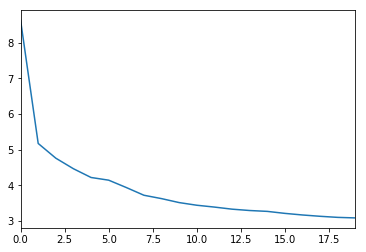

In [4]:
sns.tsplot(svd.singular_values_)

In [5]:
df = pd.DataFrame([[key,value] for key,value in docset.terms_document_frequencies.iteritems()],columns=["Term","Frequency"])

In [6]:
df_high = df[df["Frequency"] > 2000].sort_values(by=["Frequency"],ascending=False)

In [16]:
output_notebook()

Loading BokehJS ...

In [8]:
source = ColumnDataSource(df_high)

In [9]:
p = figure(plot_width=1000,plot_height=500,title="Term Frequencies",x_range=df_high["Term"].values,y_range=Range1d(0,df_high["Frequency"].max()))
p.vbar(x="Term",top = "Frequency",width=0.2,source=source)
p.add_tools(HoverTool(tooltips=[("Term","@Term"),("Frequency","@Frequency")]))
show(p)

In [10]:
terms = sorted(df["Term"])
top_n = 20
comp0 = svd.components_[6]
top_indices = comp0.argsort()[-top_n:][::-1]
for index in top_indices:
    print(terms[index])

cancer
breast
lung
patient
therapi
chemotherapi
tumor
nsclc
trial
surviv
agent
serum
treatment
women
risk
prostat
combin
ci
radiat
dose


In [8]:
from sklearn.cluster import KMeans

In [40]:
import matplotlib.pyplot as plt
from bokeh.palettes import Category20
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(docset_transofrm)
y_kmeans = kmeans.predict(docset_transofrm)

colors_list = []
for yk in y_kmeans:
    colors_list.append(Category20[20][yk])
source = ColumnDataSource(dtdf)

In [41]:
p1 = figure(plot_width=1000,plot_height=500,tools="pan,wheel_zoom,box_zoom,reset,hover")
p1.scatter(docset_transofrm[:,0],docset_transofrm[:,1],color=colors_list)
show(p1)

In [56]:
with open("/etc/rocketml.d/meta/data/lemur-stopwords.txt","r") as fp:
    stopwords = fp.readlines()

In [57]:
stopwords.append("patient\n")
stopwords.append("cell\n")

In [58]:
filename = "stopwords_pubmed.txt"
swfile = open(filename,"w")
for sw in stopwords:
    swfile.write("%s"%sw)
swfile.close()

In [3]:
docset = DocumentSet(filelist=abstract_filenames)
tf = TextFilter(stop_word_filter=True,stemming_filter=True,length_filter=True,stop_word_filename="/home/santi/workspace/rml-notebooks/stopwords_pubmed.txt")
svd = TruncatedSVD(n_components=20)
pipeline = Pipeline([tf,svd])
docset_transofrm = pipeline.fit_transform(docset)
len(docset.documents)

text
/tmp/jobs_folder/5bd19cb8/output.txt


14349

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from bokeh.palettes import Category20
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(docset_transofrm)
y_kmeans = kmeans.predict(docset_transofrm)

colors_list = []
for yk in y_kmeans:
    colors_list.append(Category20[20][yk])

In [7]:
p1 = figure(plot_width=1000,plot_height=500,tools="pan,wheel_zoom,box_zoom,reset,hover")
p1.scatter(docset_transofrm[:,0],docset_transofrm[:,1],color=colors_list)
show(p1)